# 1D Rayleigh wave phase velocity inversion

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/rayleigh_wave_phase_velocity/1D_rayleigh_wave_phase_velocity_inversion.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we look at applying CoFI to the inversion of Rayleigh wave phase velocities for a 1D layered earth.

**Learning outcomes**

- A demonstration of CoFI's ability to switch between parameter estimation and ensemble methods.
- A comparison between different McMC samplers that is fixed-d and trans-d samplers
- An application of CoFI to field data


In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi git+https://github.com/inlab-geo/pysurf96.git
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/sw_rf_joint

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from pysurf96 import surf96
import bayesbay
import cofi

## Problem description

Here we illustrate the range of inversion methods made avaialbe by CoFI. That is we first define a base problem and then explore the use of an iterative non linear apporach to find the MAP solution and then employ a range of Markov Chain Monte Carlo strategies to recover the posterior distribution. The forward problem is solved using pysurf 96 (https://github.com/miili/pysurf96) and the field data example is taken from  (https://www.eas.slu.edu/eqc/eqc_cps/TUTORIAL/STRUCT/index.html) and we will be inverting observed rayleigh wave phase velocities

**Inference problem**

In [2]:
# display theory on the inference problem
from IPython.display import display, Markdown

with open("../../theory/geo_surface_wave_dispersion.md", "r") as f:
    content = f.read()

display(Markdown(content))

A surface wave is a wave that travels along an interface between to media. Rayleigh wave and Love wave are ealstic surface waves that travel along the surface of solid media, for example the surface of the Earth. The depth to which these waves penetrate is a function of the wave type and wavelength; thus in turn the group and phase velocity at which the wave travels is a function of wavelength and wave type.

If velocity changes with depth, as is the case in the Earth, we observe what is known as surface wave dispersion, that is the phase and group velocity are a function of the freqeuncy. In contrast to this for a constant velocity half space no dispersion would occur. Thus surface wave dispersion offers a way to probe the earth, with dispersion measurements typically obtained thorugh a spectral analysis of the observed timeseries. Applications span a wide range of scales from imaging the mantle to recovering paleochannel networks. 

<figure>
<img src="../../theory/illustrations/sw_sensitivity_kernel.png" >
<figcaption align = "Sensitivity kernel of a surface wave dispersion problem">Kernel sensitivity plot that illustrates the sensitivity of the surface shear wave velocity at varying depth levels</figcaption>
</figure>


**Solving methods**

In [5]:
# display theory on the optimisation approach
with open("../../theory/inv_optimisation.md", "r") as f:
    content = f.read()

display(Markdown(content))

The objective function we are minimizing with parameter estimation is given as:

$$
\Psi(\mathbf{m}) = (\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} C_{d}^{-1}(\mathbf{d} -\mathrm{f}(\mathbf{m})) + \lambda \mathbf{m}^{T} W^{\mathrm{T}} W \mathbf{{m}},
$$

where $\mathbf{d}$ represents the data vector of measured phase velocities, $\mathrm{f}(\mathbf{m})$ is the model prediction, $C_d^{-1}$ is the inverse of the data covariance matrix, $W$ the damping matrix, $\mathbf{m}$ the model vector and $\lambda$ a regularization factor. The model update is then given as

$$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}+\lambda W^{T} W}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{d}-\mathrm{f}(\mathbf{m}))+\lambda W^{T} W \mathbf{m}}_{\mathbf{Gradient}}),
\end{equation} 
$$

where $J$ represents the Jacobian.


In [6]:
# display theory on the optimisation approach
with open("../../theory/inv_mcmc.md", "r") as f:
    content = f.read()

display(Markdown(content))

In an ensemble method we seek to sample the posterior distrbution which is the product of the prior distirbution and the likelihood function, with the likelihood given as:
$$
p(\mathbf{d}|\mathbf{m})=  \frac{1}{\sqrt{(2 \pi)^n |C_d|}} e^{-\frac{1}{2} (\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} C_{d}^{-1}(\mathbf{d} -\mathrm{f}(\mathbf{m}))} 
$$
with for practical application the log likelihood will be used.

We use a uniform distribution as the prior.


**Further reading**

https://en.wikipedia.org/wiki/Surface_wave_inversion

## Utilities

### 1D model paramterisation

In [7]:
# display theory on the 1D model parameterisation
with open("../../theory/misc_1d_model_parameterisation.md", "r") as f:
    content = f.read()

display(Markdown(content))

Here we invert for a layered earth that is we assume that at a given location the earth can be describe by a set of layer with infite extension i.e. there are no lateral variation, the earth only varies in the depth direction. The forward solver typically requires the subsurface to be parametrised a certain way and inversion methods frequenly also assume a certain model parameterisation. This example makes use of two appraoche that are frequently employed to parametrise a layered earth. As we will see later both parametrisations can capture a 1D layered earth but for the different inversion methods it is advantegous to choose one over the other. To explore different approaches we need to be able to convert between the different model parameterisations.

<figure>
<img src="../../theory/illustrations/layer_cake_voronoi.png" >
<figcaption align = "Parmaterisation of a 1D velcoity function using voronoi sites or a layers"> Layer based and voronoi site based parameterisation of a 1D laereed earth where layers have constant velocities </figcaption>
</figure>


***Layer based parameterisation***

In a layer based parameterisation the model vector is given as $\mathbf{m}=(v_1,t_1,...,v_{n-1},t_{n-1},v_n)$ where $t_i$ is the thickness of the $i$-th layer with velocity $v_i$. The last layer is a half space and thus has only a velocity parameter but no thickness parameter. 


```python
[velocity[1], thickness[1], velocity[2], thickness[2], velocity[3], ...,velocity[n-1], thickness[n-1], velocity[n]]
```


***Voronoi sites based parameterisation***

The alternative to explictly parameterising the layer thickness is to use  Voronoi sites and assing to each site a depth and a velocity. HEre the model vector is given as $\mathbf{m}=(d_1,...,d_n,v_1,...,v_n)$ where $d_i$ is the depth for the i-th vronoi site and  $v_i$ the velocity assinged to the layer represented by the voronoi site. In this parameterisation the interface between two layers is given as the halfway depth between the two corresponding Voronoi sites.

```python
[velocity[1], velocity[2], ..., velocity[n], depth[1], depth[2], ..., depth[n]]
```


In [3]:
# layercake model utilities
def form_layercake_model(thicknesses, vs):
    model = np.zeros((len(vs)*2-1,))
    model[1::2] = thicknesses
    model[::2] = vs
    return model

def split_layercake_model(model):
    thicknesses = model[1::2]
    vs = model[::2]
    return thicknesses, vs

In [4]:
# voronoi model utilities
def form_voronoi_model(voronoi_sites, vs):
    return np.hstack((vs, voronoi_sites))

def split_voronoi_model(model):
    voronoi_sites = model[len(model)//2:]
    vs = model[:len(model)//2]
    return voronoi_sites, vs

In [5]:
def voronoi_to_layercake(voronoi_vector: np.ndarray) -> np.ndarray:
    n_layers = len(voronoi_vector) // 2
    velocities = voronoi_vector[:n_layers]
    voronoi_sites = voronoi_vector[n_layers:]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    layercake_vector = np.zeros((2*n_layers-1,))
    layercake_vector[::2] = velocities
    layercake_vector[1::2] = thicknesses
    return layercake_vector

def layercake_to_voronoi(layercake_vector: np.ndarray, first_voronoi_site: float = 0.0) -> np.ndarray:
    n_layers = len(layercake_vector) // 2 + 1
    thicknesses = layercake_vector[1::2]
    velocities = layercake_vector[::2]
    depths = np.cumsum(thicknesses)
    voronoi_sites = np.zeros((n_layers,))
    for i in range(1,len(voronoi_sites)):
        voronoi_sites[i] = 2 * depths[i-1] - voronoi_sites[i-1]
    voronoi_vector = np.hstack((velocities, voronoi_sites))
    return voronoi_vector

### Forward solver

In [2]:
# display theory on the using the forward solver
with open("../../theory/geo_surface_wave_dispersion2.md", "r") as f:
    content = f.read()

display(Markdown(content))

CoFI relies on other libraries to solve the forward problem. Here we interface to pysurf96 (https://github.com/miili/pysurf96) to obtain the Rayleigh wave phase velocity dispersion curve given layer thicknesses and Vp, Vs and $\rho$ for each layer. In addtion to the forward function we also implement a function to compute a numerical Jacobian via finite differencing.

While surface waves are sensitive to the pressure wave proapgation velocity $V_p$, the shear wave propagtion velocity $V_s$ and the density $\rho$, they however have limited information content and the three parameters are trading of against each other, thus here we assume that the $V_p/V_s$ ratio is constatn that the density is a linear function of $V_p$ and only invert for $V_s$. That is in the following:
$$
V_p=1.77*V_s
$$
and
$$
\rho = 0.32*V_p* 0.77.
$$


In [6]:
# Constants
VP_VS = 1.77
RHO_VP_K = 0.32
RHO_VP_B = 0.77

In [7]:
# forward through pysurf96
def forward_sw(model, periods):
    thicknesses, vs = split_layercake_model(model)
    thicknesses = np.append(thicknesses, 10)
    vp = vs * VP_VS
    rho = RHO_VP_K * vp + RHO_VP_B
    return surf96(
        thicknesses,
        vp,
        vs,
        rho,
        periods,
        wave="rayleigh",
        mode=1,
        velocity="phase",
        flat_earth=False,
    )

# numerical jacobian
def jacobian_sw(model, periods, fwd=forward_sw, relative_step=0.01):
    jacobian = np.zeros((len(periods), len(model)))
    original_dpred = fwd(model, periods)
    for i in range(len(model)):
        perturbed_model = model.copy()
        step = relative_step * model[i]
        perturbed_model[i] += step
        perturbed_dpred = fwd(perturbed_model, periods)
        derivative = (perturbed_dpred - original_dpred) / abs(step)
        jacobian[:, i] = derivative
    return jacobian

## Visualisation

For conveninece we also implement two functions to plot the data here the Rayleigh wave phase velocity and a model given in the layer based parametrisation.

In [8]:
def plot_model(model, ax=None, title="model", **kwargs):
    # process data
    thicknesses = np.append(model[1::2], max(model[1::2]))
    velocities = model[::2]
    y = np.insert(np.cumsum(thicknesses), 0, 0)
    x = np.insert(velocities, 0, velocities[0])
    
    # plot depth profile
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 0.5)),
        "alpha": 0.2,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(kwargs)
    ax.step(x, y, where="post", **plotting_style)
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    ax.set_xlabel("Vs (km/s)")
    ax.set_ylabel("Depth (km)")
    ax.set_title(title)
    return ax

In [9]:
def plot_data(rayleigh_phase_velocities, periods, ax=None, scatter=False, 
              title="data", **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 1)),
        "alpha": 1,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(**kwargs)
    if scatter:
        ax.scatter(periods, rayleigh_phase_velocities, **plotting_style)
    else:
        ax.plot(periods, rayleigh_phase_velocities, **plotting_style)
    ax.set_xlabel("Periods (s)")
    ax.set_ylabel("Rayleigh phase velocities (km/s)")
    ax.set_title(title)
    return ax

In [10]:
def plot_model_and_data(model, label_model, color_model, 
                        forward_func, periods, label_d_pred, color_d_pred, 
                        axes=None, light_thin=False):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios": [1, 2.5]})
    ax1, ax2 = axes
    if light_thin:
        plot_model(model, ax=ax1, color=color_model, alpha=0.2, lw=0.5, label=label_model)
        plot_data(forward_func(model, periods), periods, ax=ax2, color=color_d_pred, alpha=0.2, lw=0.5, label=label_d_pred)
    else:
        plot_model(model, ax=ax1, color=color_model, alpha=1, lw=1, label=label_model)
        plot_data(forward_func(model, periods), periods, ax=ax2, color=color_d_pred, label=label_d_pred)
    ax1.legend()
    ax2.legend()
    return ax1, ax2

## Synthetic example


Prior to inverting any field data it is good practice to test an inversion method using sythetic exmaples where we know the true model. It is also recommended to prior to this idnepently test any forward solver that is being used and verify the Jacobian, as problems related to the forward sovler are diffiuclt to identify and diagnose once they are integrated in an inversion methodology.

### Generate synthetic data

In [11]:
synth_d_periods = np.geomspace(3, 80, 20)

true_thicknesses = np.array([10, 10, 15, 20, 20, 20, 20, 20])
true_vs = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
true_model = form_layercake_model(true_thicknesses, true_vs)

In [12]:
noise_level = 0.02
d_true = forward_sw(true_model, synth_d_periods)
d_obs = d_true + np.random.normal(0, 0.01, len(d_true))

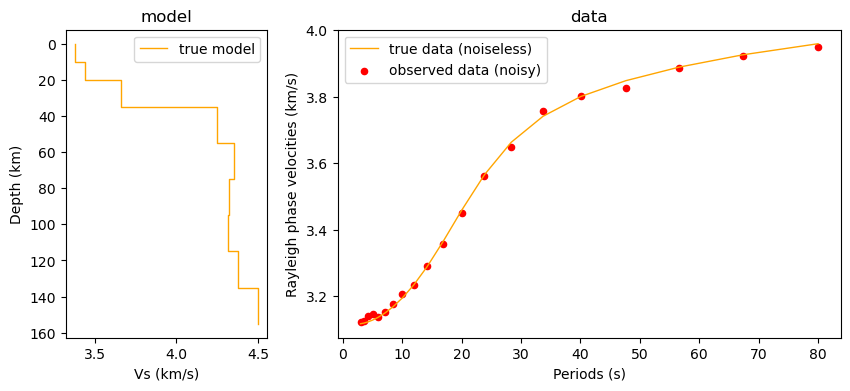

In [13]:
# plot true model and d_pred from true model
_, ax2 = plot_model_and_data(model=true_model, label_model="true model", color_model="orange",
                    forward_func=forward_sw, periods=synth_d_periods, 
                    label_d_pred="true data (noiseless)", color_d_pred="orange")

# plot d_obs
plot_data(d_obs, synth_d_periods, ax=ax2, scatter=True, color="red", s=20, label="observed data (noisy)")
ax2.legend();

### Optimisation

**Prepare `BaseProblem` for optimisation**

In [14]:
n_dims = 17

init_thicknesses = np.ones((n_dims//2,)) * 15
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

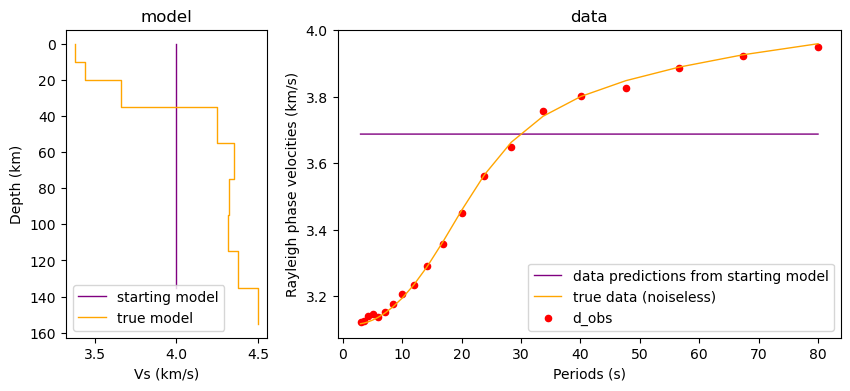

In [15]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="purple",
                           forward_func=forward_sw, periods=synth_d_periods, 
                           label_d_pred="data predictions from starting model", color_d_pred="purple")

# plot the model and d_pred for true model
plot_model_and_data(model=true_model, label_model="true model", color_model="orange",
                    forward_func=forward_sw, periods=synth_d_periods, 
                    label_d_pred="true data (noiseless)", color_d_pred="orange", axes=axes)

# plot d_obs
plot_data(d_obs, synth_d_periods, ax=axes[1], scatter=True, color="red", s=20, label="d_obs")
axes[1].legend();

In [16]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,), 
    reference_model=init_model
)

In [17]:
def my_objective(model, fwd, periods, d_obs, lamda=1.0):
    d_pred = fwd(model, periods)
    data_misfit = np.sum((d_obs - d_pred) ** 2)
    reg = my_reg(model)
    return data_misfit + lamda * reg

def my_objective_gradient(model, fwd, periods, d_obs, lamda=1.0):
    d_pred = fwd(model, periods)
    jac = jacobian_sw(model, periods, fwd)
    data_misfit_grad = -2 * jac.T @ (d_obs - d_pred)
    reg_grad = my_reg.gradient(model)
    return data_misfit_grad + lamda * reg_grad

def my_objective_hessian(model, fwd, periods, d_obs, lamda=1.0):
    jac = jacobian_sw(model, periods, fwd)
    data_misfit_hess = 2 * jac.T @ jac
    reg_hess = my_reg.hessian(model)
    return data_misfit_hess + lamda * reg_hess

#### Optimisation with no damping

In [18]:
lamda = 0

kwargs = {
    "fwd": forward_sw, 
    "periods": synth_d_periods, 
    "d_obs": d_obs, 
    "lamda": lamda
}
sw_problem_no_reg = cofi.BaseProblem()
sw_problem_no_reg.set_objective(my_objective, kwargs=kwargs)
sw_problem_no_reg.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_problem_no_reg.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_problem_no_reg.set_initial_model(init_model)

**Define `InversionOptions`**

In [19]:
inv_options_optimiser = cofi.InversionOptions()
inv_options_optimiser.set_tool("scipy.optimize.minimize")
inv_options_optimiser.set_params(method="trust-exact")

**Define `Inversion` and run**

In [20]:
inv_optimiser_no_reg = cofi.Inversion(sw_problem_no_reg, inv_options_optimiser)
inv_result_optimiser_no_reg = inv_optimiser_no_reg.run()

/home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


**Plot results**

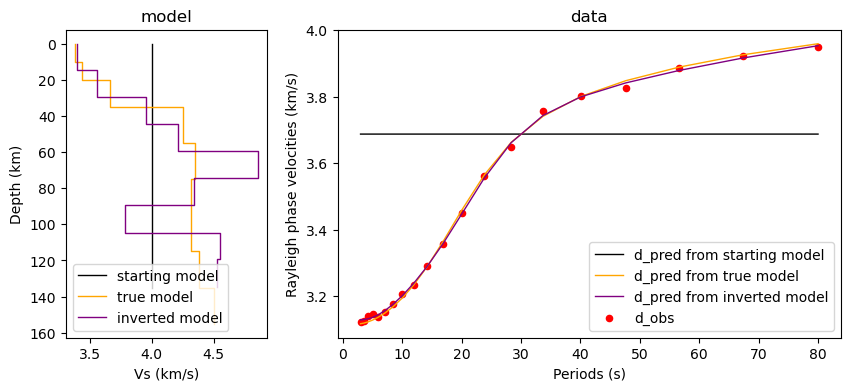

In [21]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="black",
                           forward_func=forward_sw, periods=synth_d_periods, 
                           label_d_pred="d_pred from starting model", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=true_model, label_model="true model", color_model="orange",
                    forward_func=forward_sw, periods=synth_d_periods, 
                    label_d_pred="d_pred from true model", color_d_pred="orange", axes=axes)

# plot the model and d_pred for inverted model
plot_model_and_data(model=inv_result_optimiser_no_reg.model, label_model="inverted model", color_model="purple",
                    forward_func=forward_sw, periods=synth_d_periods,
                    label_d_pred="d_pred from inverted model", color_d_pred="purple", axes=axes);

# plot d_obs
plot_data(d_obs, synth_d_periods, ax=axes[1], scatter=True, color="red", s=20, label="d_obs")
axes[1].legend();

#### Optimal damping

Obviously we get a very skewed 1D model out of an optimisation that solely tries
to minimise the data misfit. We would like to add a damping term to our objective
function, but we are not sure which factor suits the problem well.

In this situation, the `InversionPool` from CoFI can be handy.

In [22]:
lambdas = np.logspace(-6, 6, 15)

my_lcurve_problems = []
for lamb in lambdas:
    my_problem = cofi.BaseProblem()
    kwargs = {
        "fwd": forward_sw, 
        "periods": synth_d_periods, 
        "d_obs": d_obs, 
        "lamda": lamb
    }
    my_problem.set_objective(my_objective, kwargs=kwargs)
    my_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
    my_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
    my_problem.set_initial_model(init_model)
    my_lcurve_problems.append(my_problem)

def my_callback(inv_result, i):
    m = inv_result.model
    res_norm = np.linalg.norm(forward_sw(m, synth_d_periods) - d_obs)
    reg_norm = np.sqrt(my_reg(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=my_lcurve_problems,
    list_of_inv_options=inv_options_optimiser,
    callback=my_callback,
    parallel=False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=1e-06: 0.03253179180792859, 1.433451567652572
Finished inversion with lambda=7.196856730011514e-06: 0.03254648295822858, 1.2907482888115973
Finished inversion with lambda=5.1794746792312125e-05: 0.03259605186067473, 1.198419648266259
Finished inversion with lambda=0.0003727593720314938: 0.03271146825760433, 1.1777116746119674
Finished inversion with lambda=0.0026826957952797246: 0.03414642148377045, 1.1441018094483537
Finished inversion with lambda=0.019306977288832496: 0.04557148871878309, 1.1010730162384024
Finished inversion with lambda=0.1389495494373136: 0.15050981248683185, 0.9632985710396416
Finished inversion with lambda=1.0: 0.49132513505243003, 0.6475041325895361
Finished inversion with lambda=7.196856730011514: 1.0825281847885295, 0.3092179795855576
Finished inversion with lambda=51.79474679231202: 1.601368145291442, 0.06679711537490236
Finished inversion with lambda=372.7593720314938: 1.7249037142714072, 0.00999575104402415
Finished inversion 

In [23]:
# print all the lambdas
lambdas

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00,
       7.19685673e+00, 5.17947468e+01, 3.72759372e+02, 2.68269580e+03,
       1.93069773e+04, 1.38949549e+05, 1.00000000e+06])

**Plot L-curve**

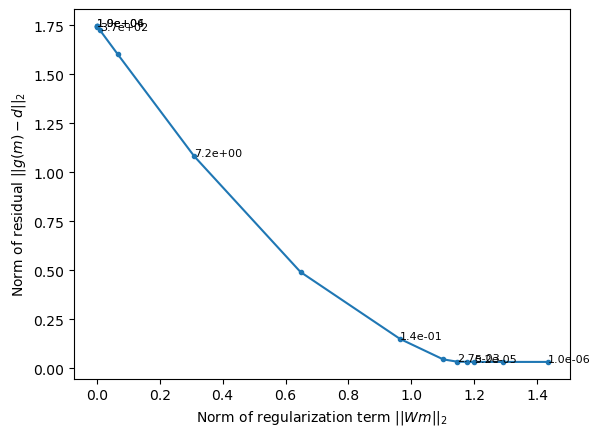

In [24]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 2):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

#### Optimisation with damping

From the L-curve plot above, it seems that a damping factor of around 0.02 would be 
good.

In [25]:
lamda = 0.02

kwargs = {
    "fwd": forward_sw, 
    "periods": synth_d_periods, 
    "d_obs": d_obs, 
    "lamda": lamda
}
sw_problem = cofi.BaseProblem()
sw_problem.set_objective(my_objective, kwargs=kwargs)
sw_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_problem.set_initial_model(init_model)

**Define `Inversion` and run**

In [26]:
inv_optimiser = cofi.Inversion(sw_problem, inv_options_optimiser)
inv_result_optimiser = inv_optimiser.run()

**Plot results**

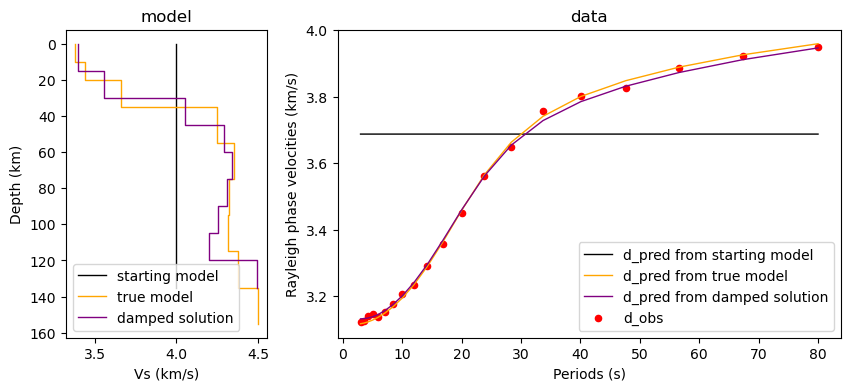

In [27]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="black",
                           forward_func=forward_sw, periods=synth_d_periods, 
                           label_d_pred="d_pred from starting model", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=true_model, label_model="true model", color_model="orange",
                    forward_func=forward_sw, periods=synth_d_periods, 
                    label_d_pred="d_pred from true model", color_d_pred="orange", axes=axes)

# plot the model and d_pred for damped solution, and d_obs
plot_model_and_data(model=inv_result_optimiser.model, label_model="damped solution", color_model="purple",
                    forward_func=forward_sw, periods=synth_d_periods,
                    label_d_pred="d_pred from damped solution", color_d_pred="purple", axes=axes);

# plot d_obs
plot_data(d_obs, synth_d_periods, ax=axes[1], scatter=True, color="red", s=20, label="d_obs")
axes[1].legend();

### Fixed-dimensional sampling

**Prepare `BaseProblem` for fixed-dimensional sampling**

In [28]:
thick_min = 5
thick_max = 30
vs_min = 2
vs_max = 5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < vs_min) | (vs > vs_max)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = -np.log(thick_max - thick_min) * len(thicknesses) - np.log(vs_max - vs_min) * len(vs)
    return log_prior

In [29]:
Cdinv = np.eye(len(d_obs))/(noise_level**2)      # inverse data covariance matrix

def my_log_likelihood(model):
    try:
        d_pred = forward_sw(model, synth_d_periods)
    except:
        return float("-inf")
    residual = d_obs - d_pred
    return -0.5 * residual @ (Cdinv @ residual).T

In [30]:
n_walkers = 40

my_walkers_start = np.ones((n_walkers, n_dims)) * inv_result_optimiser.model
for i in range(n_walkers):
    my_walkers_start[i,:] += np.random.normal(0, 0.3, n_dims)

In [31]:
sw_problem.set_log_prior(my_log_prior)
sw_problem.set_log_likelihood(my_log_likelihood)

**Define `InversionOptions`**

In [32]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers, 
    nsteps=2_000, 
    initial_state=my_walkers_start, 
    skip_initial_state_check=True, 
    progress=True
)

**Define `Inversion` and run**

We will disable the display of warnings temporarily due to the unavoidable existence of `-inf` in our prior.

https://github.com/dfm/emcee/issues/370#issuecomment-1013623444

In [33]:
np.seterr(all="ignore");

#### Sample the prior

In [34]:
prior_sampling_problem = cofi.BaseProblem()
prior_sampling_problem.set_log_posterior(my_log_prior)
prior_sampling_problem.set_model_shape(init_model.shape)
prior_sampler = cofi.Inversion(prior_sampling_problem, inv_options_fixed_d_sampling)
prior_results = prior_sampler.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1134.24it/s]


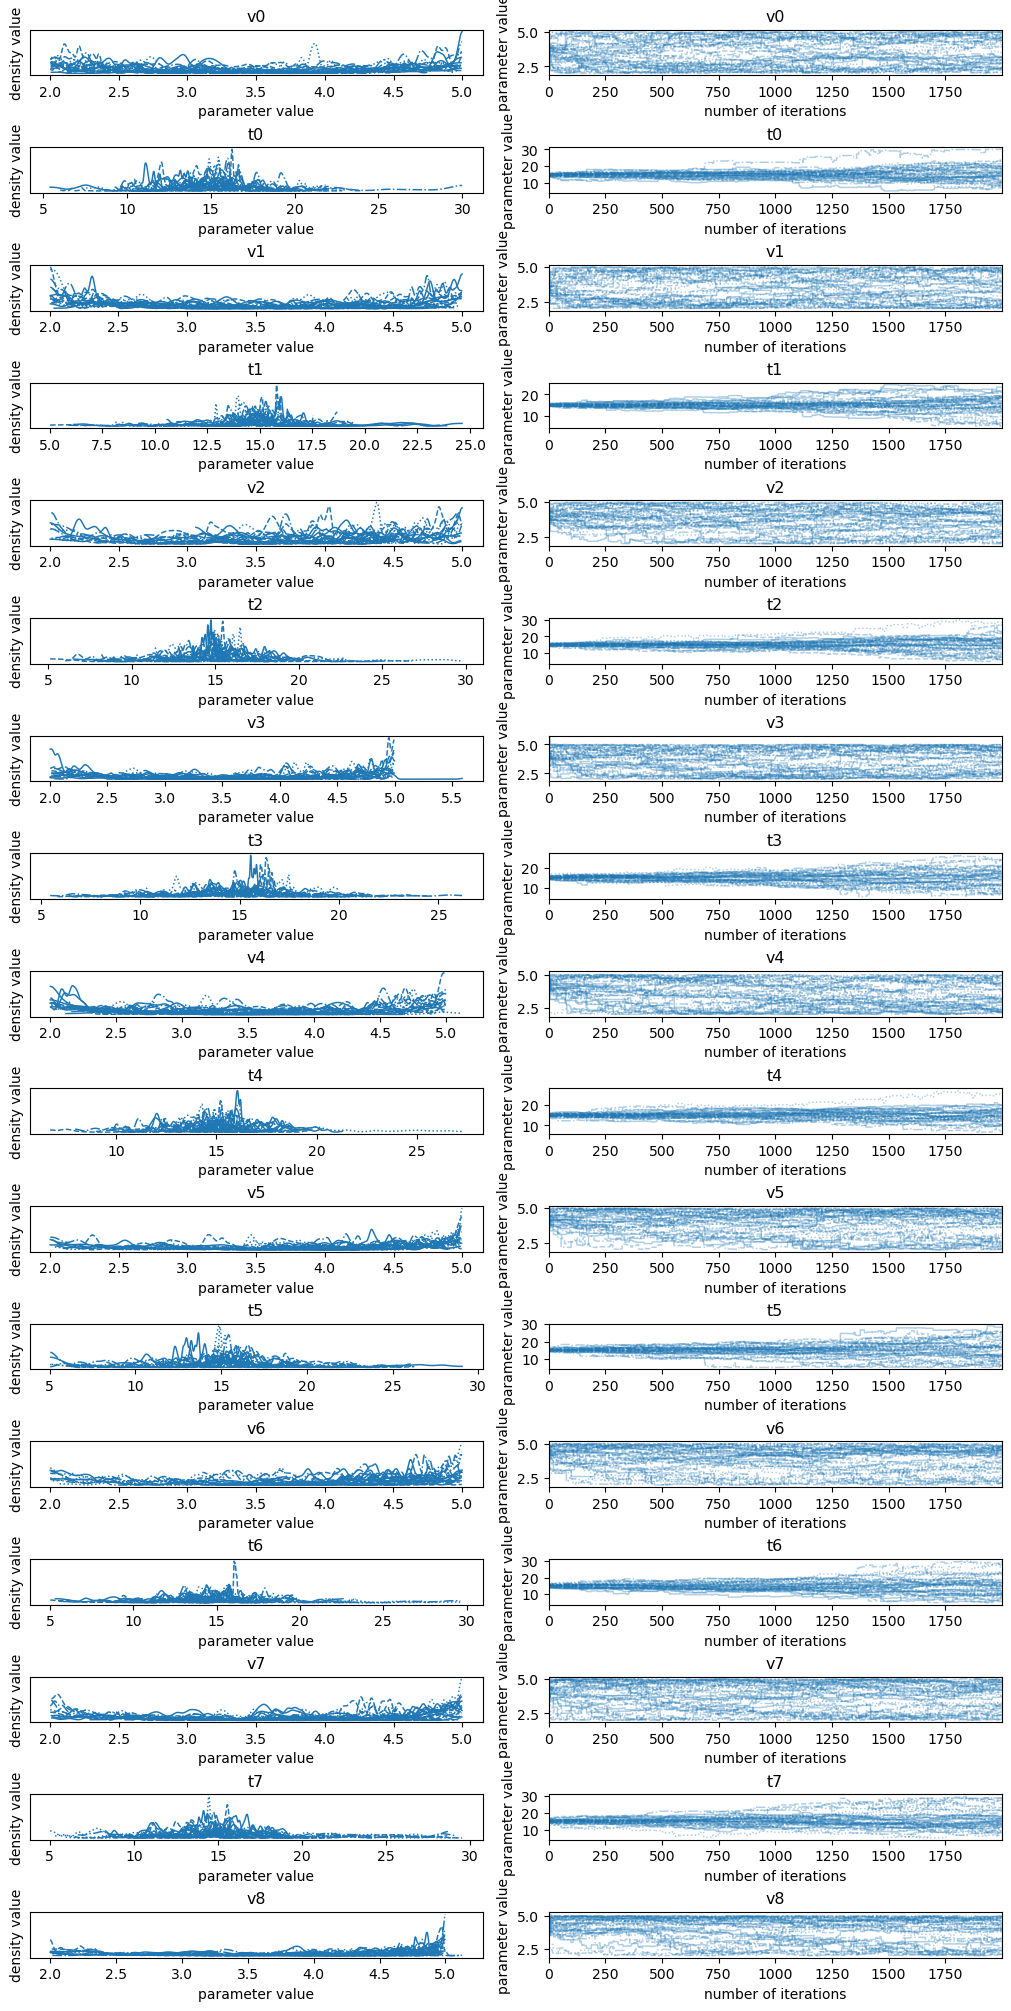

In [35]:
import arviz as az

labels = ["v0", "t0", "v1", "t1", "v2", "t2", "v3", "t3", "v4", "t4", "v5", "t5", "v6", "t6", "v7", "t7", "v8"]

prior_results_sampler = prior_results.sampler
az_idata_prior = az.from_emcee(prior_results_sampler, var_names=labels)

axes = az.plot_trace(
    az_idata_prior, 
    backend_kwargs={"constrained_layout":True}, 
    figsize=(10,20),
)

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

#### Sample the posterior

In [36]:
inversion_fixed_d_sampler = cofi.Inversion(sw_problem, inv_options_fixed_d_sampling)
inv_result_fixed_d_sampler = inversion_fixed_d_sampler.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 81.50it/s]


In [37]:
sampler = inv_result_fixed_d_sampler.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [38]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 40, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables: (12/17)
    v0       (chain, draw) float64 3.304 3.304 3.304 3.308 ... 3.424 3.422 3.422
    t0       (chain, draw) float64 15.23 15.23 15.23 15.22 ... 25.9 24.91 24.91
    v1       (chain, draw) float64 3.448 3.448 3.448 3.546 ... 4.024 3.973 3.973
    t1       (chain, draw) float64 15.19 15.19 15.19 15.16 ... 29.1 28.7 28.7
    v2       (chain, draw) float64 4.023 4.023 4.023 4.057 ... 4.618 4.615 4.615
    t2       (chain, draw) float64 15.15 15.15 15.15 15.16 ... 14.48 16.11 16.11
    ...       ...
    t5       (chain, draw) float64 14.83 14.83 14.83 14.81 ... 26.4 22.29 22.29
    v6       (chain, draw) float64 3.813 3.813 3.813 3.871 ... 4.314 4.272 4.272
    t6       (chain, draw) float64 14.41 14.41 14.41 14.5 ... 9.527 8.778 8.778
    v7       (chain, draw) float64 4.11 4.11 4.11 4.146 ... 3.8 3.8 3.758 3.758
    t7       (chain, draw) float64 14.81 14.81 14.81 14.84 ... 20.98 18.38 18.38
    v8       (chain, draw) float64 4.467 4.467 4.467 4.454 ... 4.786 4.744 4.744
Attributes:
    created_at:                 2024-04-12T10:17:27.824097
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

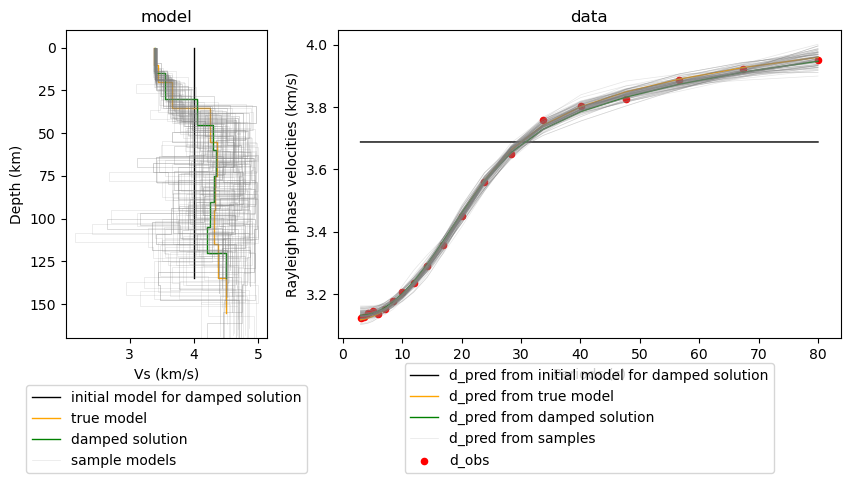

In [39]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="initial model for damped solution", color_model="black",
                           forward_func=forward_sw, periods=synth_d_periods, 
                           label_d_pred="d_pred from initial model for damped solution", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=true_model, label_model="true model", color_model="orange",
                    forward_func=forward_sw, periods=synth_d_periods, 
                    label_d_pred="d_pred from true model", color_d_pred="orange", axes=axes)

# plot the model and d_pred for damped solution, and d_obs
plot_model_and_data(model=inv_result_optimiser.model, label_model="damped solution", color_model="green",
                    forward_func=forward_sw, periods=synth_d_periods,
                    label_d_pred="d_pred from damped solution", color_d_pred="green", axes=axes);

# plot randomly selected samples and data predictions from samples
flat_samples = sampler.get_chain(discard=500, thin=500, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)
for idx in rand_indices:
    sample = flat_samples[idx]
    label_model = "sample models" if idx == 0 else None
    label_d_pred = "d_pred from samples" if idx == 0 else None
    plot_model_and_data(model=sample, label_model=label_model, color_model="gray",
                        forward_func=forward_sw, periods=synth_d_periods,
                        label_d_pred=label_d_pred, color_d_pred="gray", axes=axes, light_thin=True)

# plot d_obs
plot_data(d_obs, synth_d_periods, ax=axes[1], scatter=True, color="red", s=20, label="d_obs")

axes[0].set_ylim(170)
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46))
axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

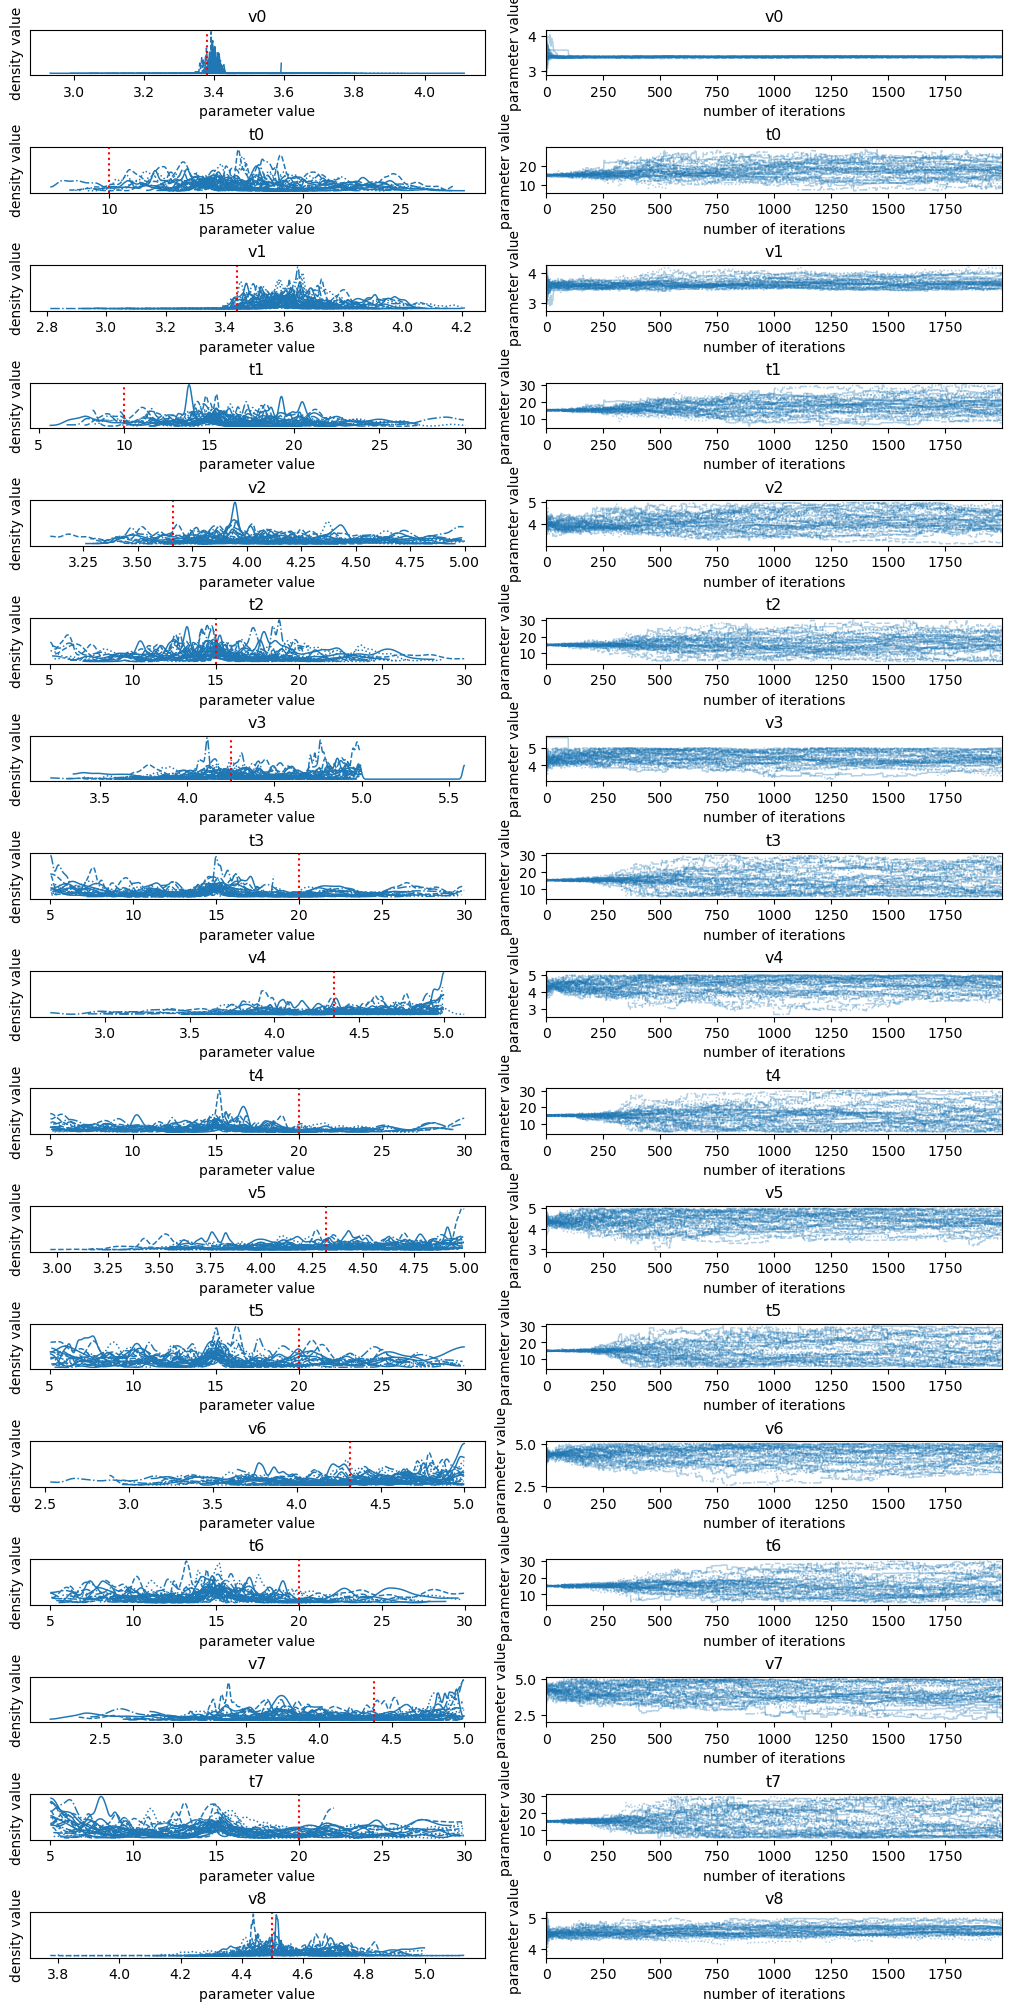

In [40]:
axes = az.plot_trace(
    az_idata, 
    backend_kwargs={"constrained_layout":True},
    figsize=(10,20)
)

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

**More steps?**

Due to time restrictions, we have only run 2_000 steps above, which might be
enough for illustration purpose and sanity check, but are not enough for an actual
inversion.

On a seperate experiment, we ran 200_000 steps instead and produced the following
samples plot.

![Fixed-dimensional sampling results with 200_000 steps](https://raw.githubusercontent.com/inlab-geo/cofi-examples/main/tutorials/rayleigh_wave_phase_velocity/illustrations/emcee_200_000_iterations.png?raw=true)

### Trans-dimensional sampling

**Prepare utilities for trans-dimensional sampling**

In [41]:
def forward_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return forward_sw(model, synth_d_periods)

In [42]:
targets = [bayesbay.Target("rayleigh", d_obs, covariance_mat_inv=1/noise_level**2)]
fwd_funcs = [forward_for_bayesbay]
my_log_likelihood = bayesbay.LogLikelihood(targets, fwd_funcs)

In [43]:
param_vs = bayesbay.prior.UniformPrior(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [44]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=15, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_functions

In [45]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

**Define `InversionOptions`**

In [46]:
inv_options_trans_d_sampling = cofi.InversionOptions()
inv_options_trans_d_sampling.set_tool("bayesbay")
inv_options_trans_d_sampling.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood,
    n_chains=n_chains, 
    n_iterations=3_000, 
    burnin_iterations=1_000,
    verbose=False, 
    save_every=200, 
)

**Define `Inversion` and run**

In [47]:
inversion_trans_d_sampler = cofi.Inversion(sw_problem, inv_options_trans_d_sampling)
inv_result_trans_d_sampler = inversion_trans_d_sampler.run()

In [48]:
inverted_models = inv_result_trans_d_sampler.models
samples = []
for v, vs in zip(inverted_models["voronoi.discretization"], inverted_models["voronoi.vs"]):
    sample = form_voronoi_model(v, vs)
    samples.append(voronoi_to_layercake(sample))

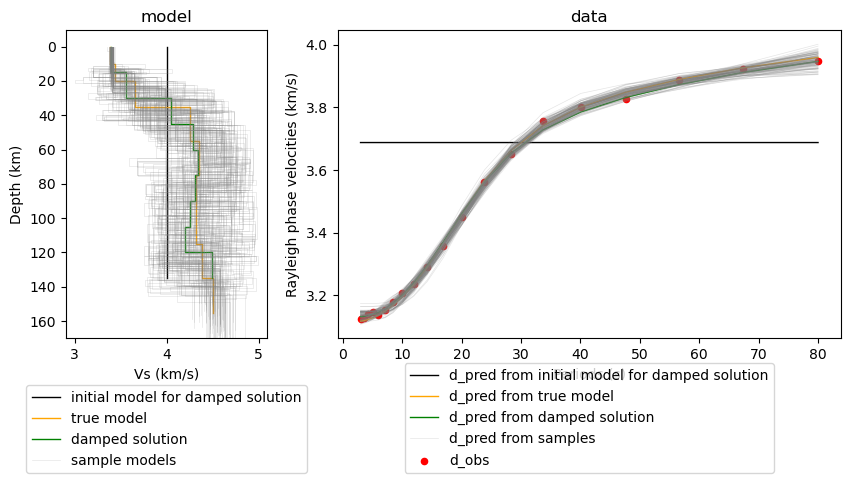

In [49]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="initial model for damped solution", color_model="black",
                           forward_func=forward_sw, periods=synth_d_periods, 
                           label_d_pred="d_pred from initial model for damped solution", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=true_model, label_model="true model", color_model="orange",
                    forward_func=forward_sw, periods=synth_d_periods, 
                    label_d_pred="d_pred from true model", color_d_pred="orange", axes=axes)

# plot the model and d_pred for damped solution, and d_obs
plot_model_and_data(model=inv_result_optimiser.model, label_model="damped solution", color_model="green",
                    forward_func=forward_sw, periods=synth_d_periods,
                    label_d_pred="d_pred from damped solution", color_d_pred="green", axes=axes);

# plot randomly selected samples and data predictions from samples
for i, sample in enumerate(samples):
    label_model = "sample models" if i == 0 else None
    label_d_pred = "d_pred from samples" if i == 0 else None
    plot_model_and_data(model=sample, label_model=label_model, color_model="gray",
                        forward_func=forward_sw, periods=synth_d_periods,
                        label_d_pred=label_d_pred, color_d_pred="gray", axes=axes, light_thin=True)

# plot d_obs
plot_data(d_obs, synth_d_periods, ax=axes[1], scatter=True, color="red", s=20, label="d_obs")

axes[0].set_ylim(170)
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46))
axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

## Field data example

### Read data

**Rayleigh observations**

In [50]:
file_surf_data = "../../data/sw_rf_joint/data/SURF/nnall.dsp"

with open(file_surf_data, "r") as file:
    lines = file.readlines()
    surf_data = []
    for line in lines:
        row = line.strip().split()
        if "C" in row:
            surf_data.append([float(e) for e in row[5:8]])

field_d = np.array(surf_data)
field_d_periods = field_d[:,0]
field_d_obs = field_d[:,1]

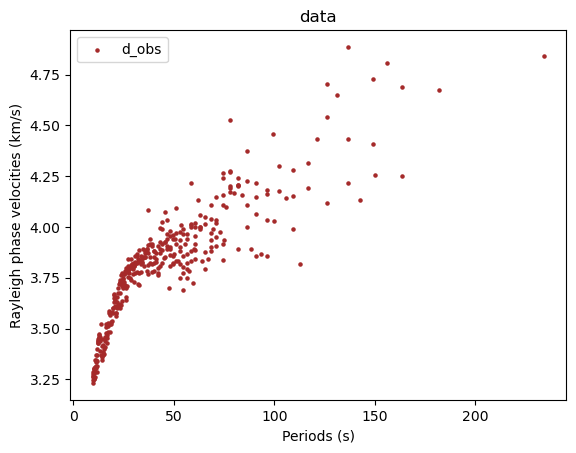

In [51]:
ax = plot_data(field_d_obs, field_d_periods, color="brown", s=5, scatter=True,
             label="d_obs")
ax.legend();

**Reference good model**

In [52]:
file_end_mod = "../../data/sw_rf_joint/data/SURF/end.mod"

with open(file_end_mod, "r") as file:
    lines = file.readlines()
    ref_good_model = []
    for line in lines[12:]:
        row = line.strip().split()
        ref_good_model.append([float(row[0]), float(row[2])])

ref_good_model = np.array(ref_good_model)
ref_good_model = form_layercake_model(ref_good_model[:-1,0], ref_good_model[:,1])

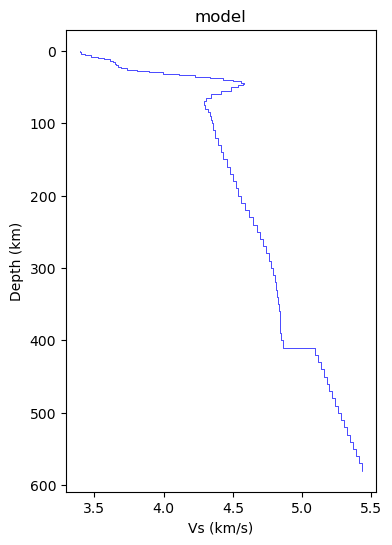

In [53]:
_, ax = plt.subplots(figsize=(4,6))
plot_model(ref_good_model, ax=ax, alpha=1);

### Modified forward utility

In [54]:
def forward_sw_interp(model, periods=field_d_periods):
    pysurf_periods = np.logspace(
        np.log(np.min(periods)), 
        np.log(np.max(periods+1)), 
        60,
        base=np.e, 
    )
    pysurf_dpred = forward_sw(model, pysurf_periods)
    interp_func = scipy.interpolate.interp1d(pysurf_periods, 
                                             pysurf_dpred, 
                                             fill_value="extrapolate")
    dpred = interp_func(periods)
    return dpred

### Optimisation

In [55]:
n_dims = 29

init_thicknesses = np.ones((n_dims//2,)) * 10
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

In [56]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,), 
    reference_model=init_model
)

#### Optimisation with no damping

In [57]:
lamda = 0

kwargs = {
    "fwd": forward_sw_interp,
    "periods": field_d_periods, 
    "d_obs": field_d_obs, 
    "lamda": lamda, 
}
sw_field_problem_no_reg = cofi.BaseProblem()
sw_field_problem_no_reg.set_objective(my_objective, kwargs=kwargs)
sw_field_problem_no_reg.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_field_problem_no_reg.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_field_problem_no_reg.set_initial_model(init_model)

**Define `Inversion` and run**

In [58]:
inv_sw_field_problem_no_reg = cofi.Inversion(sw_field_problem_no_reg, inv_options_optimiser)
inv_result_sw_field_no_reg = inv_sw_field_problem_no_reg.run()

/home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


**Plot results**

In [60]:
field_d_periods_logspace = np.logspace(
    np.log(np.min(field_d_periods)), 
    np.log(np.max(field_d_periods+1)), 
    60, 
    base=np.e, 
)

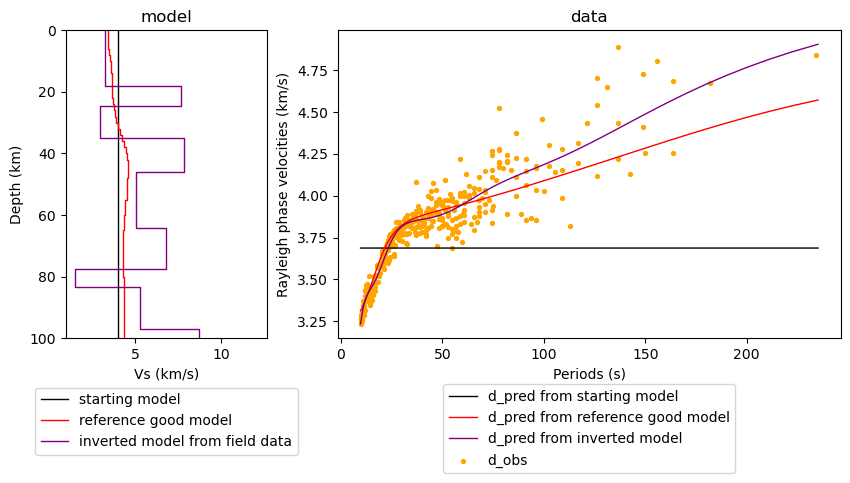

In [61]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="black",
                           forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                           label_d_pred="d_pred from starting model", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=ref_good_model, label_model="reference good model", color_model="red",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                    label_d_pred="d_pred from reference good model", color_d_pred="red", axes=axes)

# plot the model and d_pred for inverted model, and d_obs
plot_model_and_data(model=inv_result_sw_field_no_reg.model, 
                    label_model="inverted model from field data", color_model="purple",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace,
                    label_d_pred="d_pred from inverted model", color_d_pred="purple", axes=axes)

# plot d_obs
plot_data(field_d_obs, field_d_periods, ax=axes[1], scatter=True, color="orange", s=8, label="d_obs")

axes[0].set_ylim(100, 0)
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

#### Optimal damping

Again, we would like to find a good regularisation factor.

In [62]:
lambdas = np.logspace(-6, 6, 15)

my_lcurve_problems = []
for lamb in lambdas:
    my_problem = cofi.BaseProblem()
    kwargs = {
        "fwd": forward_sw_interp,
        "periods": field_d_periods, 
        "d_obs": field_d_obs, 
        "lamda": lamb, 
    }
    my_problem.set_objective(my_objective, kwargs=kwargs)
    my_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
    my_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
    my_problem.set_initial_model(init_model)
    my_lcurve_problems.append(my_problem)

def my_callback(inv_result, i):
    m = inv_result.model
    res_norm = np.linalg.norm(forward_sw_interp(m, field_d_periods) - field_d_obs)
    reg_norm = np.sqrt(my_reg(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=my_lcurve_problems,
    list_of_inv_options=inv_options_optimiser,
    callback=my_callback,
    parallel=False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=1e-06: 1.9541990490401067, 26.344915306571828
Finished inversion with lambda=7.196856730011514e-06: 1.9553224319271587, 21.28568824550561
Finished inversion with lambda=5.1794746792312125e-05: 1.9674089962897339, 10.740245919864481
Finished inversion with lambda=0.0003727593720314938: 1.9698991462825037, 7.647768305345091
Finished inversion with lambda=0.0026826957952797246: 1.9782440845733156, 4.551629520495997
Finished inversion with lambda=0.019306977288832496: 2.0050549438091747, 2.3442273803058176
Finished inversion with lambda=0.1389495494373136: 2.0393073369018655, 1.6477206878151607
Finished inversion with lambda=1.0: 2.112939266124699, 1.3870331002558798
Finished inversion with lambda=7.196856730011514: 2.7878693578372693, 0.990760151448259
Finished inversion with lambda=51.79474679231202: 4.890126438918003, 0.34475194170977674
Finished inversion with lambda=372.7593720314938: 5.957321022746526, 0.06129962536156985
Finished inversion with lambda=

In [63]:
# print all the lambdas
lambdas

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00,
       7.19685673e+00, 5.17947468e+01, 3.72759372e+02, 2.68269580e+03,
       1.93069773e+04, 1.38949549e+05, 1.00000000e+06])

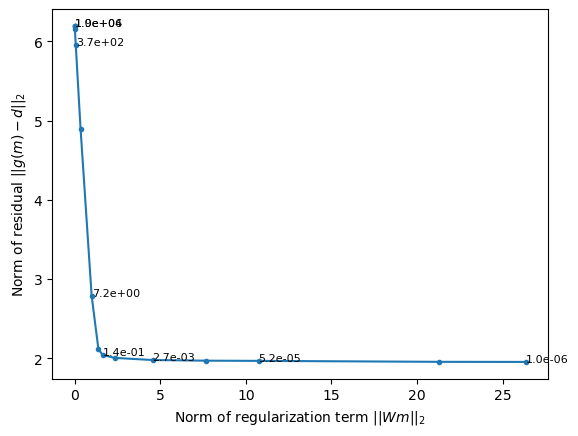

In [64]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 2):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

#### Optimisation with damping

In [65]:
lamda = 0.14

kwargs = {
    "fwd": forward_sw_interp,
    "periods": field_d_periods, 
    "d_obs": field_d_obs, 
    "lamda": lamda, 
}
sw_field_problem = cofi.BaseProblem()
sw_field_problem.set_objective(my_objective, kwargs=kwargs)
sw_field_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_field_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_field_problem.set_initial_model(init_model)

**Define `Inversion` and run**

In [66]:
inv_sw_field_problem = cofi.Inversion(sw_field_problem, inv_options_optimiser)
inv_result_sw_field = inv_sw_field_problem.run()

**Plot results**

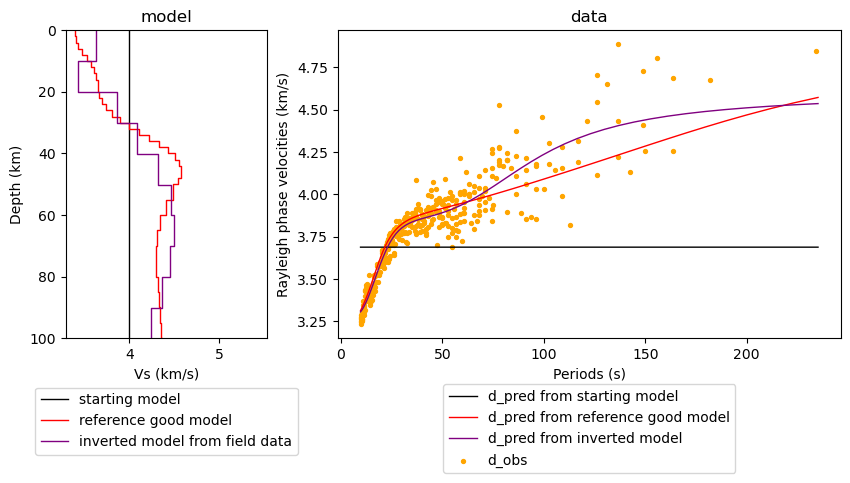

In [67]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="black",
                           forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                           label_d_pred="d_pred from starting model", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=ref_good_model, label_model="reference good model", color_model="red",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                    label_d_pred="d_pred from reference good model", color_d_pred="red", axes=axes)

# plot the model and d_pred for inverted model, and d_obs
plot_model_and_data(model=inv_result_sw_field.model, 
                    label_model="inverted model from field data", color_model="purple",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace,
                    label_d_pred="d_pred from inverted model", color_d_pred="purple", axes=axes)

# plot d_obs
plot_data(field_d_obs, field_d_periods, ax=axes[1], scatter=True, color="orange", s=8, label="d_obs")

axes[0].set_ylim(100, 0)
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

### Fixed-dimensional sampling

We are going to use the same sets of log prior, and we will rewrite the log likelihood
function to apply on the field data.

In [68]:
thick_min = 3
thick_max = 10
vs_min = 2
vs_max = 5.5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < vs_min) | (vs > vs_max)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = - np.log(thick_max - thick_min) * len(thicknesses) \
                - np.log(vs_max - vs_min) * len(vs)
    return log_prior

In [69]:
# estimate the data noise
d_pred_from_optimiser = forward_sw_interp(inv_result_sw_field.model, field_d_periods)
noise_level = np.std(field_d_obs - d_pred_from_optimiser)
Cdinv = np.eye(len(field_d_obs))/(noise_level**2)

print(f"Estimated noise level: {noise_level}")

Estimated noise level: 0.10587785944399025


In [70]:
def my_log_likelihood(model):
    try:
        d_pred = forward_sw_interp(model, field_d_periods)
    except:
        return float("-inf")
    residual = field_d_obs - d_pred
    return -0.5 * residual @ (Cdinv @ residual).T

In [71]:
n_walkers = 60

my_walkers_start = np.ones((n_walkers, n_dims)) * inv_result_sw_field.model
for i in range(n_walkers):
    my_walkers_start[i,:] += np.random.normal(0, 0.3, n_dims)

In [72]:
sw_field_problem.set_log_prior(my_log_prior)
sw_field_problem.set_log_likelihood(my_log_likelihood)

**Define `InversionOptions`**

In [73]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers,
    nsteps=20_000,
    initial_state=my_walkers_start,
    skip_initial_state_check=True,
    progress=True
)

#### Sample the posterior

In [74]:
inversion_fixed_d_sampler_field = cofi.Inversion(sw_field_problem,
                                                 inv_options_fixed_d_sampling)
inv_result_fixed_d_sampler_field = inversion_fixed_d_sampler_field.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [28:04<00:00, 11.87it/s]


In [75]:
sampler = inv_result_fixed_d_sampler.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [76]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 40, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables: (12/17)
    v0       (chain, draw) float64 3.304 3.304 3.304 3.308 ... 3.424 3.422 3.422
    t0       (chain, draw) float64 15.23 15.23 15.23 15.22 ... 25.9 24.91 24.91
    v1       (chain, draw) float64 3.448 3.448 3.448 3.546 ... 4.024 3.973 3.973
    t1       (chain, draw) float64 15.19 15.19 15.19 15.16 ... 29.1 28.7 28.7
    v2       (chain, draw) float64 4.023 4.023 4.023 4.057 ... 4.618 4.615 4.615
    t2       (chain, draw) float64 15.15 15.15 15.15 15.16 ... 14.48 16.11 16.11
    ...       ...
    t5       (chain, draw) float64 14.83 14.83 14.83 14.81 ... 26.4 22.29 22.29
    v6       (chain, draw) float64 3.813 3.813 3.813 3.871 ... 4.314 4.272 4.272
    t6       (chain, draw) float64 14.41 14.41 14.41 14.5 ... 9.527 8.778 8.778
    v7       (chain, draw) float64 4.11 4.11 4.11 4.146 ... 3.8 3.8 3.758 3.758
    t7       (chain, draw) float64 14.81 14.81 14.81 14.84 ... 20.98 18.38 18.38
    v8       (chain, draw) float64 4.467 4.467 4.467 4.454 ... 4.786 4.744 4.744
Attributes:
    created_at:                 2024-04-12T10:47:38.456362
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

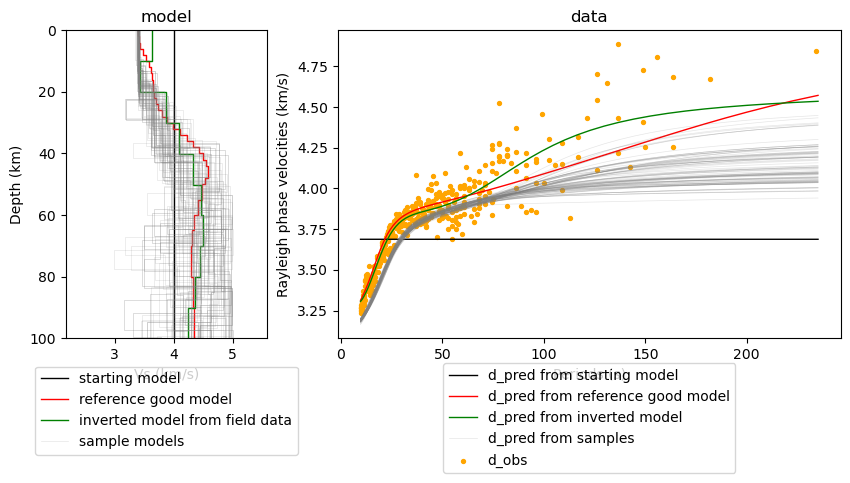

In [77]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="black",
                           forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                           label_d_pred="d_pred from starting model", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=ref_good_model, label_model="reference good model", color_model="red",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                    label_d_pred="d_pred from reference good model", color_d_pred="red", axes=axes)

# plot the model and d_pred for inverted model, and d_obs
plot_model_and_data(model=inv_result_sw_field.model, 
                    label_model="inverted model from field data", color_model="green",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace,
                    label_d_pred="d_pred from inverted model", color_d_pred="green", axes=axes)

# plot randomly selected samples and data predictions from samples
flat_samples = sampler.get_chain(discard=1000, thin=300, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)
for idx in rand_indices:
    sample = flat_samples[idx]
    label_model = "sample models" if idx == 0 else None
    label_d_pred = "d_pred from samples" if idx == 0 else None
    plot_model_and_data(model=sample, label_model=label_model, color_model="gray",
                        forward_func=forward_sw_interp, periods=field_d_periods_logspace,
                        label_d_pred=label_d_pred, color_d_pred="gray", axes=axes, light_thin=True)

# plot d_obs
plot_data(field_d_obs, field_d_periods, ax=axes[1], scatter=True, color="orange", s=8, label="d_obs")

axes[0].set_ylim(100, 0)
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

**More steps**

Similar to our earlier fixed-dimensional sampling run on the synthetic data, we are
not sampling enough due to time limit.

On a seperate experiment, we ran 200_000 steps and produced the following samples
plot.

![Fixed-dimensional sampling results on field data with 200_000 steps](https://raw.githubusercontent.com/inlab-geo/cofi-examples/main/tutorials/rayleigh_wave_phase_velocity/illustrations/emcee_200_000_iterations_field.png?raw=true)

### Trans-dimensional sampling

In [78]:
def forward_interp_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return forward_sw_interp(model, field_d_periods)

In [79]:
targets = [bayesbay.Target("rayleigh", field_d_obs, covariance_mat_inv=1/noise_level**2)]
fwd_funcs = [forward_interp_for_bayesbay]
my_log_likelihood = bayesbay.LogLikelihood(targets, fwd_funcs)

In [80]:
param_vs = bayesbay.prior.UniformPrior(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [81]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=20, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_functions

In [82]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

**Define `InversionOptions`**

In [83]:
inv_options_field_trans_d_sampling = cofi.InversionOptions()
inv_options_field_trans_d_sampling.set_tool("bayesbay")
inv_options_field_trans_d_sampling.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood,
    n_chains=n_chains, 
    n_iterations=3_000, 
    burnin_iterations=1_000,
    verbose=False, 
    save_every=200, 
)

**Define `Inversion` and run**

In [84]:
inversion_field_trans_d_sampler = cofi.Inversion(sw_field_problem, 
                                                 inv_options_field_trans_d_sampling)
inv_result_field_trans_d_sampler = inversion_field_trans_d_sampler.run()

In [85]:
inverted_models = inv_result_field_trans_d_sampler.models
samples = []
for v, vs in zip(inverted_models["voronoi.discretization"], inverted_models["voronoi.vs"]):
    sample = form_voronoi_model(v, vs)
    samples.append(voronoi_to_layercake(sample))

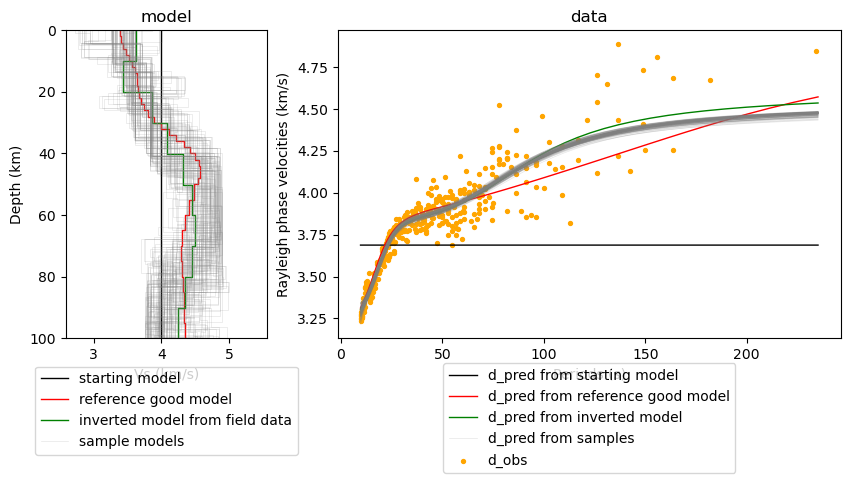

In [86]:
# plot the model and d_pred for starting model
axes = plot_model_and_data(model=init_model, label_model="starting model", color_model="black",
                           forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                           label_d_pred="d_pred from starting model", color_d_pred="black")

# plot the model and d_pred for true model
plot_model_and_data(model=ref_good_model, label_model="reference good model", color_model="red",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace, 
                    label_d_pred="d_pred from reference good model", color_d_pred="red", axes=axes)

# plot the model and d_pred for inverted model, and d_obs
plot_model_and_data(model=inv_result_sw_field.model, 
                    label_model="inverted model from field data", color_model="green",
                    forward_func=forward_sw_interp, periods=field_d_periods_logspace,
                    label_d_pred="d_pred from inverted model", color_d_pred="green", axes=axes)

# plot randomly selected samples and data predictions from samples
flat_samples = sampler.get_chain(discard=1000, thin=300, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)
for i, sample in enumerate(samples):
    label_model = "sample models" if i == 0 else None
    label_d_pred = "d_pred from samples" if i == 0 else None
    plot_model_and_data(model=sample, label_model=label_model, color_model="gray",
                        forward_func=forward_sw_interp, periods=field_d_periods_logspace,
                        label_d_pred=label_d_pred, color_d_pred="gray", axes=axes, light_thin=True)

# plot d_obs
plot_data(field_d_obs, field_d_periods, ax=axes[1], scatter=True, color="orange", s=8, label="d_obs")

axes[0].set_ylim(100, 0)
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

---
## Watermark

In [87]:
watermark_list = ["cofi", "numpy", "matplotlib", "scipy", "emcee", "bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
numpy 1.23.5
matplotlib 3.7.1
scipy 1.10.1
emcee 3.1.4
bayesbay 0.3.0
